# ===================================================================
# **TENSORFLOW 1.XX  TOTURIAL - Example**
* This notebook implement MLP network on MNIST datasets!
* Written by **Alireza Khodabakhsh**
* alireza.khodabakhsh@ee.sharif.edu
* Aban 1400, October 2021
# ===================================================================

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install rarfile

# 1. import library

In [ ]:
import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import math
import matplotlib.pyplot as plt
import numpy as np
import rarfile
import pandas as pd
from numpy.random import RandomState


Instructions for updating:
non-resource variables are not supported in the long term


# 2. import Dataset

# 3. Train/Test/Valid & One Hot

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/Q1_train.csv')
df2 = pd.read_csv('/content/drive/MyDrive/Q1_test.csv')
rng = RandomState()

train = df1.sample(frac=0.7, random_state=rng)
valid = df1.loc[~df1.index.isin(train.index)]

num_valid=valid.shape[0]
num_train=train.shape[0]

x_test=df2.iloc[:,1:]
x_test = np.array(x_test, dtype='uint32')/255
y_test=df2.iloc[:,0]

y_train=train.iloc[:,0]
x_train =train.iloc[:,1:]
x_train = np.array(x_train, dtype='uint32')/255

y_valid=valid.iloc[:,0]
x_valid =valid.iloc[:,1:]
x_valid = np.array(x_valid, dtype='uint32')/255

y_train_hot=tf.Session().run(tf.one_hot(y_train,25))
y_valid_hot=tf.Session().run(tf.one_hot(y_valid,25))
y_test_hot=tf.Session().run(tf.one_hot(y_test,25))
tf.Session().close()

# 4. Shuffle

In [ ]:
x_train_shaffle=tf.Session().run(tf.random.shuffle(x_train, seed=12321 ))
y_train_shaffle=tf.Session().run(tf.random.shuffle(y_train_hot, seed=12321))

# 5. HyperParameters

In [ ]:
num_feature=x_train.shape[1]
num_class=25
rl=0.001
batchsize=100
normal_std=0.001

# 6. Functions that we'll need

In [ ]:
def WEIGHTS(shape, name) :
    return tf.get_variable(dtype=tf.float32, shape=shape,name='W_'+name,
                  initializer=tf.truncated_normal_initializer(stddev=0.001))

In [ ]:
def BIAS (shape, name):
    return tf.get_variable(dtype=tf.float32, shape=(shape) , name='B_'+name,
                  initializer=tf.zeros_initializer())

In [ ]:
def FC(X, num_units, name, relu=False):
    in_dim=X.get_shape()[1]
    W=WEIGHTS((in_dim, num_units), name)
    B=BIAS ((num_units), name)
    H=tf.matmul(X,W)
    O=tf.add(H,B)
    if relu==True:
        return tf.nn.relu(O)
    return O,W

# 7. Neural Network ( Graph Phase )

In [ ]:
tf.reset_default_graph()
input_image=tf.placeholder(dtype=tf.float32, shape=(None,num_feature),
                           name='INPUT')


FC1=FC(input_image, 512, 'FC1', relu=True)

H2=FC(FC1, 25, 'FC2', relu=False)

output_image=tf.placeholder(dtype=tf.float32, shape=(None, num_class),
                           name='OUTPUT')

# 8. Neural Network ( Graph Phase ) - Optimization 

In [ ]:
loss= tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=output_image, logits= H2,
                                            name='LOSS'))
adam=tf.train.AdamOptimizer (
    learning_rate=rl, name='Adam'
).minimize(loss)

sgd=tf.train.GradientDescentOptimizer (
    learning_rate=rl, name='SGD'
).minimize(loss)

accuracy=tf.reduce_mean(tf.cast(tf.math.equal(tf.argmax(H2,axis=1),tf.argmax(output_image,axis=1)),dtype=tf.float32))
find_misclass=tf.where(tf.math.logical_not(tf.math.equal(tf.argmax(H2,axis=1),tf.argmax(output_image,axis=1))))



Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



# 9. Neural Network ( Session Phase )  with adam optimizer

In [ ]:
plot_valid_loss=[]
plot_valid_accuracy=[]
plot_train_loss=[]
plot_train_accuracy=[]
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

loss_tb= tf.summary.scalar('LOSS_TENSORBOARD' ,loss)
accuracy_tb= tf.summary.scalar('accuracy_TENSORBOARD' ,accuracy)
write = tf.summary.FileWriter('./graphs', sess.graph)

for epoch in range(30):
    print('==================================================')
    print('====== Epoch=%s =================================== ' %(epoch))
    print('==================================================')
    for i in range(math.floor(num_train/batchsize)):
        f={input_image:x_train_shaffle[i*batchsize : (i+1)*batchsize] , 
          output_image:y_train_shaffle[i*batchsize : (i+1)*batchsize] }
        
        sess.run(adam,feed_dict=f)
        #write.add_summary(sess.run(loss_tb),epoch)
        if i%100==0:
          print('iter {}: \t Loss={:.2f} \t training accuracy={:.2f} '.format(i,sess.run(loss,feed_dict=f),sess.run(accuracy,feed_dict=f)))
    plot_train_loss.append(sess.run(loss,feed_dict=f))
    plot_train_accuracy.append(sess.run(accuracy,feed_dict=f))
    f_valid={input_image:x_valid , 
            output_image:y_valid_hot}
    
    

    print('--------------------------------------------------')
    print('Epoch:{} \t Validation Loss:{:.2f} \t validation accuracy={:.2f}'.format(epoch,sess.run(loss,feed_dict=f_valid),sess.run(accuracy,feed_dict=f_valid)))
    print('--------------------------------------------------')
    plot_valid_loss.append(sess.run(loss,feed_dict=f_valid))
    plot_valid_accuracy.append(sess.run(accuracy,feed_dict=f_valid))




====== Epoch=0 =================================== 
iter 0: 	 Loss=3.19 	 training accuracy=0.08 
iter 100: 	 Loss=2.60 	 training accuracy=0.19 
--------------------------------------------------
Epoch:0 	 Validation Loss:2.03 	 validation accuracy=0.34
--------------------------------------------------
====== Epoch=1 =================================== 
iter 0: 	 Loss=2.06 	 training accuracy=0.39 
iter 100: 	 Loss=1.89 	 training accuracy=0.44 
--------------------------------------------------
Epoch:1 	 Validation Loss:1.56 	 validation accuracy=0.50
--------------------------------------------------
====== Epoch=2 =================================== 
iter 0: 	 Loss=1.62 	 training accuracy=0.51 
iter 100: 	 Loss=1.53 	 training accuracy=0.48 
--------------------------------------------------
Epoch:2 	 Validation Loss:1.31 	 validation accuracy=0.58
--------------------------------------------------
====== Epoch=3 =================================== 
iter 0: 	 Loss=1.37 	 training

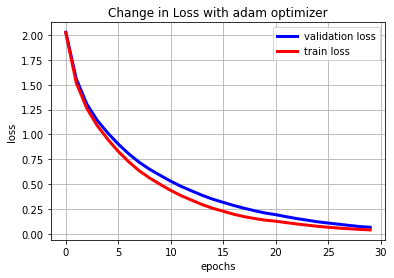

In [ ]:
plt.plot(range(epoch+1),plot_valid_loss,label='validation loss', color='b',LineWidth=3)
plt.plot(range(epoch+1),plot_train_loss,label='train loss', color='r',LineWidth=3)
plt.title("Change in Loss with adam optimizer")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()

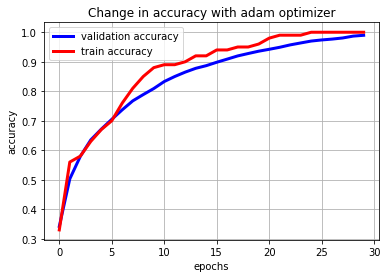

In [ ]:
plt.plot(range(epoch+1),plot_valid_accuracy,label='validation accuracy', color='b',LineWidth=3)
plt.plot(range(epoch+1),plot_train_accuracy,label='train accuracy', color='r',LineWidth=3)
plt.title("Change in accuracy with adam optimizer")
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.grid()
plt.show()

# 10. Neural Network ( Session Phase )  with gradient descent optimizer

In [ ]:
plot_valid_loss=[]
plot_valid_accuracy=[]
plot_train_loss=[]
plot_train_accuracy=[]
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
for epoch in range(30):
    print('==================================================')
    print('====== Epoch=%s =================================== ' %(epoch))
    print('==================================================')
    for i in range(math.floor(num_train/batchsize)):
        f={input_image:x_train_shaffle[i*batchsize : (i+1)*batchsize] , 
          output_image:y_train_shaffle[i*batchsize : (i+1)*batchsize] }
        sess.run(sgd,feed_dict=f)
        if i%100==0:
          print('iter {}: \t Loss={:.2f} \t training accuracy={:.2f} '.format(i,sess.run(loss,feed_dict=f),sess.run(accuracy,feed_dict=f)))
    plot_train_loss.append(sess.run(loss,feed_dict=f))
    plot_train_accuracy.append(sess.run(accuracy,feed_dict=f))
    f_valid={input_image:x_valid , 
            output_image:y_valid_hot}
    print('--------------------------------------------------')
    print('Epoch:{} \t Validation Loss:{:.2f} \t validation accuracy={:.2f}'.format(epoch,sess.run(loss,feed_dict=f_valid),sess.run(accuracy,feed_dict=f_valid)))
    print('--------------------------------------------------')
    plot_valid_loss.append(sess.run(loss,feed_dict=f_valid))
    plot_valid_accuracy.append(sess.run(accuracy,feed_dict=f_valid))




/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1766: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


====== Epoch=0 =================================== 
iter 0: 	 Loss=3.22 	 training accuracy=0.09 
iter 100: 	 Loss=3.22 	 training accuracy=0.07 
--------------------------------------------------
Epoch:0 	 Validation Loss:3.22 	 validation accuracy=0.04
--------------------------------------------------
====== Epoch=1 =================================== 
iter 0: 	 Loss=3.22 	 training accuracy=0.07 
iter 100: 	 Loss=3.22 	 training accuracy=0.03 
--------------------------------------------------
Epoch:1 	 Validation Loss:3.22 	 validation accuracy=0.04
--------------------------------------------------
====== Epoch=2 =================================== 
iter 0: 	 Loss=3.22 	 training accuracy=0.07 
iter 100: 	 Loss=3.22 	 training accuracy=0.03 
--------------------------------------------------
Epoch:2 	 Validation Loss:3.22 	 validation accuracy=0.04
--------------------------------------------------
====== Epoch=3 =================================== 
iter 0: 	 Loss=3.22 	 training

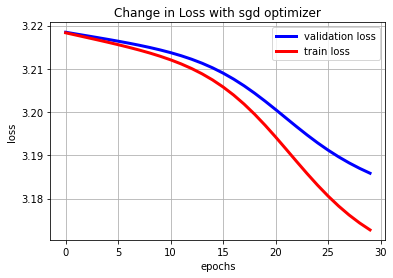

In [ ]:
plt.plot(range(epoch+1),plot_valid_loss,label='validation loss', color='b',LineWidth=3)
plt.plot(range(epoch+1),plot_train_loss,label='train loss', color='r',LineWidth=3)
plt.title("Change in Loss with sgd optimizer")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()

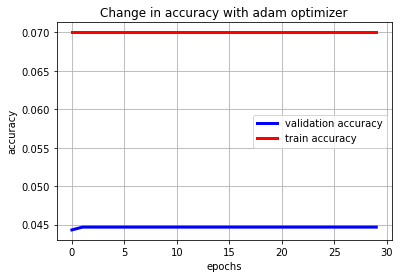

In [ ]:
plt.plot(range(epoch+1),plot_valid_accuracy,label='validation accuracy', color='b',LineWidth=3)
plt.plot(range(epoch+1),plot_train_accuracy,label='train accuracy', color='r',LineWidth=3)
plt.title("Change in accuracy with adam optimizer")
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.grid()
plt.show()

# 11. Add Dropout layer


In [ ]:
tf.reset_default_graph()
input_image=tf.placeholder(dtype=tf.float32, shape=(None,num_feature),
                           name='INPUT')

keep = tf.placeholder(dtype=tf.float32)

FC1=FC(input_image, 512, 'FC1', relu=True)
o1 = tf.nn.dropout(FC1, keep_prob=keep)

H2=FC(o1, 25, 'FC2', relu=False)



output_image=tf.placeholder(dtype=tf.float32, shape=(None, num_class),
                           name='OUTPUT')

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
loss= tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=output_image, logits= H2,
                                            name='LOSS'))
adam=tf.train.AdamOptimizer (
    learning_rate=rl, name='Adam'
).minimize(loss)

accuracy=tf.reduce_mean(tf.cast(tf.math.equal(tf.argmax(H2,axis=1),tf.argmax(output_image,axis=1)),dtype=tf.float32))
find_misclass=tf.where(tf.math.logical_not(tf.math.equal(tf.argmax(H2,axis=1),tf.argmax(output_image,axis=1))))

loss_tensorboard= tf.summary.scalar('LOSS_TENSORBOARD' ,loss)
accuracy_tb= tf.summary.scalar('accuracy_TENSORBOARD' ,accuracy)

In [ ]:
plot_valid_loss=[]
plot_valid_accuracy=[]
plot_train_loss=[]
plot_train_accuracy=[]
sess = tf.InteractiveSession()
write = tf.summary.FileWriter('./graphs', sess.graph)
sess.run(tf.global_variables_initializer())
for epoch in range(30):
    print('==================================================')
    print('====== Epoch=%s =================================== ' %(epoch))
    print('==================================================')
    for i in range(math.floor(num_train/batchsize)):
        f={input_image:x_train_shaffle[i*batchsize : (i+1)*batchsize] , 
          output_image:y_train_shaffle[i*batchsize : (i+1)*batchsize],keep:0.5 }
        sess.run(adam,feed_dict=f)
        if i%100==0:
          print('iter {}: \t Loss={:.2f} \t training accuracy={:.2f} '.format(i,sess.run(loss,feed_dict=f),sess.run(accuracy,feed_dict=f)))

    plot_train_loss.append(sess.run(loss,feed_dict=f))
    plot_train_accuracy.append(sess.run(accuracy,feed_dict=f))
    f_valid={input_image:x_valid , 
            output_image:y_valid_hot,keep:0.5}
    print('--------------------------------------------------')
    print('Epoch:{} \t Validation Loss:{:.2f} \t validation accuracy={:.2f}'.format(epoch,sess.run(loss,feed_dict=f_valid),sess.run(accuracy,feed_dict=f_valid)))
    print('--------------------------------------------------')
    plot_valid_loss.append(sess.run(loss,feed_dict=f_valid))
    plot_valid_accuracy.append(sess.run(accuracy,feed_dict=f_valid))
    



/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1766: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


====== Epoch=0 =================================== 
iter 0: 	 Loss=3.19 	 training accuracy=0.08 
iter 100: 	 Loss=2.85 	 training accuracy=0.17 
--------------------------------------------------
Epoch:0 	 Validation Loss:2.33 	 validation accuracy=0.27
--------------------------------------------------
====== Epoch=1 =================================== 
iter 0: 	 Loss=2.30 	 training accuracy=0.26 
iter 100: 	 Loss=2.16 	 training accuracy=0.29 
--------------------------------------------------
Epoch:1 	 Validation Loss:1.91 	 validation accuracy=0.39
--------------------------------------------------
====== Epoch=2 =================================== 
iter 0: 	 Loss=1.96 	 training accuracy=0.43 
iter 100: 	 Loss=1.87 	 training accuracy=0.43 
--------------------------------------------------
Epoch:2 	 Validation Loss:1.68 	 validation accuracy=0.45
--------------------------------------------------
====== Epoch=3 =================================== 
iter 0: 	 Loss=1.79 	 training

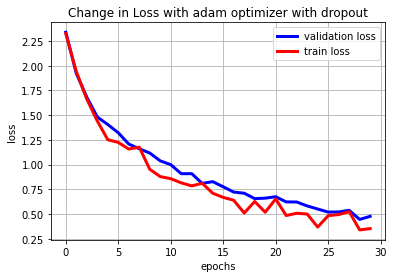

In [ ]:
plt.plot(range(epoch+1),plot_valid_loss,label='validation loss', color='b',LineWidth=3)
plt.plot(range(epoch+1),plot_train_loss,label='train loss', color='r',LineWidth=3)
plt.title("Change in Loss with adam optimizer with dropout")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()

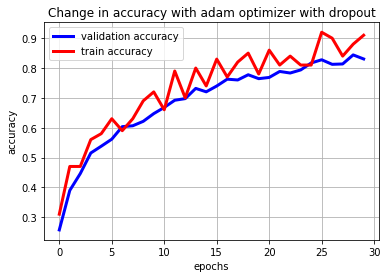

In [ ]:
plt.plot(range(epoch+1),plot_valid_accuracy,label='validation accuracy', color='b',LineWidth=3)
plt.plot(range(epoch+1),plot_train_accuracy,label='train accuracy', color='r',LineWidth=3)
plt.title("Change in accuracy with adam optimizer with dropout")
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.grid()
plt.show()

# 12. Add batch normalization layer


In [ ]:
tf.reset_default_graph()
input_image=tf.placeholder(dtype=tf.float32, shape=(None,num_feature),
                           name='INPUT')

keep = tf.placeholder(dtype=tf.float32)

FC1=FC(input_image, 512, 'FC1', relu=True)

inputs_shape = FC1.get_shape()
inputs_rank = inputs_shape.ndims
axis = range(1, inputs_rank)
mean_x_1, std_x_1 = tf.nn.moments(FC1, axis, keep_dims=True)
bn1 = tf.nn.batch_normalization(FC1,mean_x_1, std_x_1, None, None, 1e-12)

FC2=FC(bn1, 256, 'FC2', relu=True)

inputs_shape = FC2.get_shape()
inputs_rank = inputs_shape.ndims
axis = range(1, inputs_rank)
mean_x_2, std_x_2 = tf.nn.moments(FC2, axis, keep_dims=True)
bn2 = tf.nn.batch_normalization(FC2,mean_x_2, std_x_2 , None, None, 1e-12)

FC3=FC(bn2, 128, 'FC3', relu=True)

inputs_shape = FC3.get_shape()
inputs_rank = inputs_shape.ndims
axis = range(1, inputs_rank)
mean_x_3, std_x_3 = tf.nn.moments(FC3, axis , keep_dims=True)
bn3 = tf.nn.batch_normalization(FC3,mean_x_3, std_x_3, None, None, 1e-12)

H2=FC(bn3, 25, 'FC4', relu=False)



output_image=tf.placeholder(dtype=tf.float32, shape=(None, num_class),
                           name='OUTPUT')

In [ ]:
loss= tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=output_image, logits= H2,
                                            name='LOSS'))
adam=tf.train.AdamOptimizer (
    learning_rate=rl, name='Adam'
).minimize(loss)


accuracy=tf.reduce_mean(tf.cast(tf.math.equal(tf.argmax(H2,axis=1),tf.argmax(output_image,axis=1)),dtype=tf.float32))
find_misclass=tf.where(tf.math.logical_not(tf.math.equal(tf.argmax(H2,axis=1),tf.argmax(output_image,axis=1))))

loss_tb= tf.summary.scalar('LOSS_TENSORBOARD' ,loss)
accuracy_tb= tf.summary.scalar('accuracy_TENSORBOARD' ,accuracy)

In [ ]:
plot_valid_loss=[]
plot_valid_accuracy=[]
plot_train_loss=[]
plot_train_accuracy=[]
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
for epoch in range(17):
    print('==================================================')
    print('====== Epoch=%s =================================== ' %(epoch))
    print('==================================================')
    for i in range(math.floor(num_train/batchsize)):
        f={input_image:x_train_shaffle[i*batchsize : (i+1)*batchsize] , 
          output_image:y_train_shaffle[i*batchsize : (i+1)*batchsize]}
        sess.run(adam,feed_dict=f)
        if i%100==0:
          print('iter {}: \t Loss={:.2f} \t training accuracy={:.2f} '.format(i,sess.run(loss,feed_dict=f),sess.run(accuracy,feed_dict=f)))
          print(H2)
    plot_train_loss.append(sess.run(loss,feed_dict=f))
    plot_train_accuracy.append(sess.run(accuracy,feed_dict=f))
    f_valid={input_image:x_valid , 
            output_image:y_valid_hot}
    print('--------------------------------------------------')
    print('Epoch:{} \t Validation Loss:{:.2f} \t validation accuracy={:.2f}'.format(epoch,sess.run(loss,feed_dict=f_valid),sess.run(accuracy,feed_dict=f_valid)))
    print('--------------------------------------------------')
    plot_valid_loss.append(sess.run(loss,feed_dict=f_valid))
    plot_valid_accuracy.append(sess.run(accuracy,feed_dict=f_valid))




/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1766: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


====== Epoch=0 =================================== 
iter 0: 	 Loss=3.20 	 training accuracy=0.07 
Tensor("Add_3:0", shape=(?, 25), dtype=float32)
iter 100: 	 Loss=3.18 	 training accuracy=0.03 
Tensor("Add_3:0", shape=(?, 25), dtype=float32)
--------------------------------------------------
Epoch:0 	 Validation Loss:3.18 	 validation accuracy=0.04
--------------------------------------------------
====== Epoch=1 =================================== 
iter 0: 	 Loss=3.18 	 training accuracy=0.08 
Tensor("Add_3:0", shape=(?, 25), dtype=float32)
iter 100: 	 Loss=2.73 	 training accuracy=0.07 
Tensor("Add_3:0", shape=(?, 25), dtype=float32)
--------------------------------------------------
Epoch:1 	 Validation Loss:2.57 	 validation accuracy=0.15
--------------------------------------------------
====== Epoch=2 =================================== 
iter 0: 	 Loss=2.40 	 training accuracy=0.23 
Tensor("Add_3:0", shape=(?, 25), dtype=float32)
iter 100: 	 Loss=2.39 	 training accuracy=0.13 
Te

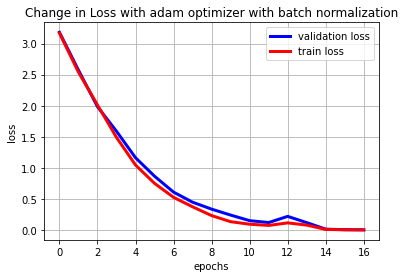

In [ ]:
plt.plot(range(epoch+1),plot_valid_loss,label='validation loss', color='b',LineWidth=3)
plt.plot(range(epoch+1),plot_train_loss,label='train loss', color='r',LineWidth=3)
plt.title("Change in Loss with adam optimizer with batch normalization")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()

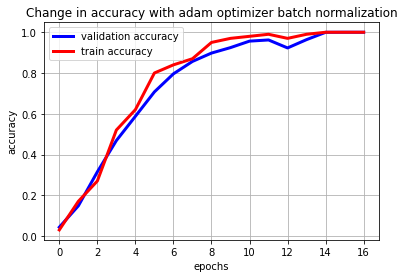

In [ ]:
plt.plot(range(epoch+1),plot_valid_accuracy,label='validation accuracy', color='b',LineWidth=3)
plt.plot(range(epoch+1),plot_train_accuracy,label='train accuracy', color='r',LineWidth=3)
plt.title("Change in accuracy with adam optimizer batch normalization")
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.grid()
plt.show()

# confusion matrix

In [ ]:
# test ur network

f={input_image:x_test , 
          output_image:y_test_hot}
print(sess.run(loss,feed_dict=f))
print(sess.run(accuracy,feed_dict=f))

prediction=tf.argmax(tf.nn.softmax(H2),1)
aa = prediction.eval(feed_dict={input_image: x_test}, session=sess)
print ("predictions :", aa)

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(aa,y_test,normalize = 'true')

maxx = np.unravel_index(np.argmax(cm, axis=None), cm.shape) 
maxx = maxx[0]
print(maxx)


0.98037905
0.76728946
predictions : [ 6  5 20 ...  2  4  2]
13


In [ ]:
print(df1.shape[0])

27455


In [ ]:
my_list = []
df = np.array(df1)
for i in range(df1.shape[0]):
  if df[i,0] == maxx:
    my_list.append([])
    

#print(len(my_list))

cnt = 0
for j in range(df1.shape[0]):
  if df[j,0] == maxx:
   my_list[cnt] = df[j,:]/255
   cnt+=1


In [ ]:
# Down sampling
gfg = np.random.uniform(0,1,math.floor(len(my_list)/5))

# train again !!!!!!!!!!!!!!!!!!!!!     :)))))))))))))))))))




# display cm matrix

In [ ]:
#disp = ConfusionMatrixDisplay( confusion_matrix=cm, display_labels=None)

#fig, ax = plt.subplots(figsize=(12,12))
#disp = disp.plot(ax=ax,cmap = plt.cm.Blues)
#ax.set_title("confusion matrix")
#plt.show()

# 13. 


# 14. 

photo capture

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


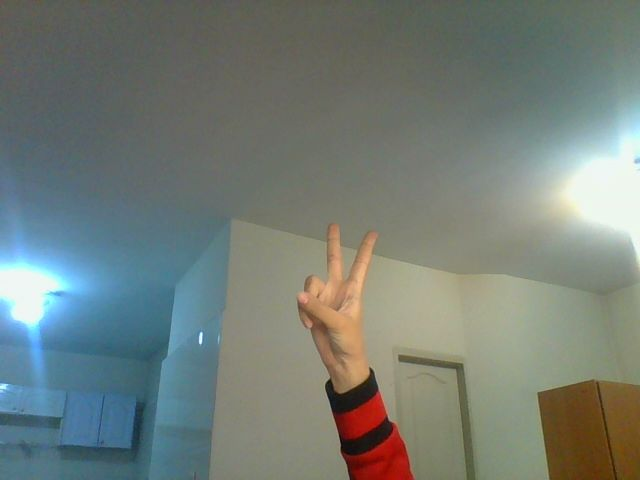

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

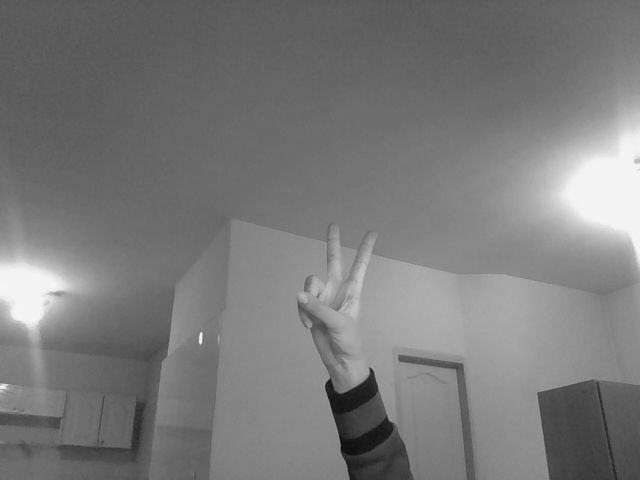

In [ ]:
from PIL import Image

img = Image.open('photo.jpg')
imgGray = img.convert('L')
imgGray.save('test.jpg')
display(imgGray)

In [ ]:
import cv2
img=cv2.imread('test.jpg',cv2.IMREAD_UNCHANGED)
img= cv2.resize(img,(28,28))

img = img.reshape((1,784))/255
print(img.shape)

(1, 784)


In [ ]:
prediction=tf.argmax(tf.nn.softmax(H2),1)
aa = prediction.eval(feed_dict={input_image: img}, session=sess)
print ("predictions :", aa)


predictions : [1]
